# Machine Learning - Project 2

## Shwetasree Chowdhury 

## UBID : 50296995 

In [200]:
import numpy as np
import matplotlib.pyplot as plt
import math
import keras
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.utils import to_categorical
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
import pandas as pd
import sklearn.metrics as skm
import keras.backend as K
from keras.layers import Conv2D, MaxPooling2D, Conv1D,MaxPooling1D
import os
import gzip

In [206]:
def getSoftPredictions(t):
    if t.ndim == 1:
        prs = np.argmax(t)
    else:
        prs = np.argmax(t,axis = 1)
    return prs 

def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,'%s-labels-idx1-ubyte.gz'% kind)
    images_path = os.path.join(path,'%s-images-idx3-ubyte.gz'% kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,offset=8)
        #labels = np.frombuffer(lbpath.read(),offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,offset=16).reshape(len(labels), 28, 28)
        #images = np.frombuffer(imgpath.read(),offset=16)
    return images, labels

In [207]:
class formatting:
   BOLD = '\033[1m'
   END = '\033[0m'

In [208]:
def plotModelHistory(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validate'], loc='lower right')
    plt.savefig('accuracy.png')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validate'], loc='upper right')
    plt.savefig('loss.png')
    plt.show()

In [209]:
classLabels = [1,2,3,4,5,6,7,8,9,10]
classNames = ['T-shirt','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle-Boot']

# Reading Data

The data is read from the .gz files provided

In [210]:
(train_data, train_label) = load_mnist('data/fashion', kind='train')
(test_data, test_label) = load_mnist('data/fashion', kind='t10k')
print("train_data shape:", train_data.shape, "train_label shape:", train_label.shape)
print("test_data shape:", test_data.shape, "test_label shape:", test_label.shape)

train_data shape: (60000, 28, 28) train_label shape: (60000,)
test_data shape: (10000, 28, 28) test_label shape: (10000,)


In [211]:
#(train_data, train_label), (test_data, test_label) = keras.datasets.fashion_mnist.load_data()
#print("train_data shape:", train_data.shape, "train_label shape:", train_label.shape)
#print("test_data shape:", test_data.shape, "test_label shape:", test_label.shape)

# Normalize data

The data is normalized to get the values between 0 and 1 for better processing

In [212]:
train_data=train_data/255.0
test_data=test_data/255.0

# Shuffle Data

The data is shuffled to incorporate randomization so that the model learns better

In [213]:
np.random.seed(seed=1)
train_label_new = train_label.reshape(len(train_label),1)
fulldata = np.concatenate((train_data.reshape(len(train_data),784), train_label_new), axis=1)
np.random.shuffle(fulldata)
train_data = fulldata[:,:784].reshape(len(train_data),28,28)
train_label = fulldata[:,784]
print("train_data shape:", train_data.shape, "train_label shape:", train_label.shape)

test_label_new = test_label.reshape(len(test_label),1)
fulltestdata = np.concatenate((test_data.reshape(len(test_data),784),test_label_new),axis=1)
np.random.shuffle(fulltestdata)
test_data = fulltestdata[:,:784].reshape(len(test_data),28,28)
test_label = fulltestdata[:,784]
print("test_data shape:", test_data.shape, "test_label shape:", test_label.shape)

train_data shape: (60000, 28, 28) train_label shape: (60000,)
test_data shape: (10000, 28, 28) test_label shape: (10000,)


# Seperate Data for different classifiers

In [214]:
nn_train_data = train_data
nn_train_labels_1hot = np_utils.to_categorical(np.array(train_label),num_classes=10)
nn_test_data = test_data
nn_test_labels_1hot = np_utils.to_categorical(np.array(test_label),num_classes=10)

cnn_train_data = train_data
cnn_train_labels_1hot = np_utils.to_categorical(np.array(train_label),num_classes=10)
cnn_test_data = test_data
cnn_test_labels_1hot = np_utils.to_categorical(np.array(test_label),num_classes=10)

sgd_nn_train_data = train_data.reshape(len(train_data),784)
sgd_nn_test_data = test_data.reshape(len(test_data),784)
sgd_nn_train_labels_1hot = np_utils.to_categorical(np.array(train_label),num_classes=10)
sgd_nn_test_labels_1hot = np_utils.to_categorical(np.array(test_label),num_classes=10)

# Neural Network with Gradient Descent

## Initializing weights for the output and hidden layer 

The weights are initialized with small values lying between 0 and 1. Biases are initialized as zeros. The number of hidden nodes taken are 128 and since the number of classes are 10, the output nodes taken are 10. The input nodes will be equal to the number of features we have i.e. 784

In [215]:
num_hidden_nodes = 128
output_nodes = 10
input_nodes = sgd_nn_train_data.shape[1]

wh = np.random.rand(input_nodes,num_hidden_nodes)
wo = np.random.rand(num_hidden_nodes,output_nodes)
bh = np.zeros((1,num_hidden_nodes))
bo = np.zeros((1,output_nodes))

In [216]:
# function to calculate the derivate of the sigmoid function
def sigmoid_derivative(z):
    return sigmoid(z) *(1-sigmoid (z))

#def sigmoid_derivative(z):
#    return z *(1-z)

# function to calculate sigmoid
def sigmoid(x):
    return 1/(1+np.exp(-x))

# function to calculate softmax
def softmax(z):
    numer = np.exp(z - np.max(z, axis=1, keepdims=True))
    return numer/np.sum(numer, axis=1, keepdims=True)

# function that calculates the outputs of the hidden layer and the final output layer
def forwardPropagation(data):
    zh = np.dot(data, wh) + bh
    ah = sigmoid(zh)
    zo = np.dot(ah, wo) + bo
    ao = softmax(zo)
    return ah,ao

#function to calculate the loss/cost after predictions. The cost function take is the cross-entropy
def getLoss(pred,target):
    logp = - np.log(pred[np.arange(target.shape[0]), target.argmax(axis=1)])
    return np.sum(logp)/target.shape[0]

#function to predict the classes
def predict(data):
    ah,ao = forwardPropagation(data)
    return ao.argmax(axis=1)

#function to calculate accuracy
def getAccuracy(t,y):
    d = y - t
    acc = 1.0 - (float(np.count_nonzero(d)) / len(d))
    return acc * 100

## Training the Model 

Here we do the forward porpagation and propagate the error back to update the weights. This is done until a number of epochs until the error is minimized and we get a good value of the weights. Learning rate is varied as well as the number of epochs to find the best accuracy.

In [217]:
lr = 0.7

error_cost = []
train_acc = []
sgd_epochs = 1000

for epoch in range(sgd_epochs):
    
    # FORWARD PROPAGATION
    ah,ao = forwardPropagation(sgd_nn_train_data)
    
    # BACK PROPAGATION
    # calculating cross entropy
    ao_delta = ao - sgd_nn_train_labels_1hot 
    ao_delta = ao_delta/sgd_nn_train_labels_1hot.shape[0]
    
    #calculating derivatives
    zh_delta = np.dot(ao_delta,wo.T)
    ah_delta = zh_delta * sigmoid_derivative(ah)
    
    #updating weights
    wo -= lr * np.dot(ah.T,ao_delta)
    bo -= lr * np.sum(ao_delta,axis=0,keepdims=True)
    wh -= lr * np.dot(sgd_nn_train_data.T,ah_delta)
    bh -= lr * np.sum(ah_delta, axis=0)
    
    #calculating loss and printing
    loss = getLoss(ao,sgd_nn_train_labels_1hot)
    error_cost.append(loss)
    predictions = ao.argmax(axis=1)
    acc = getAccuracy(train_label,predictions)
    train_acc.append(acc)
    if epoch % 100 == 0:
        print('Loss function value: ', loss)

Loss function value:  3.462535684533646
Loss function value:  0.9330519743745173
Loss function value:  0.7269699917780819
Loss function value:  0.6666667027762223
Loss function value:  0.6379534741937283
Loss function value:  0.6366969664465577
Loss function value:  0.6291710949130664
Loss function value:  0.6095747319360657
Loss function value:  0.5892883672273709
Loss function value:  0.5804653337935689


## Plotting the loss and accuracy for training and testing on test set 

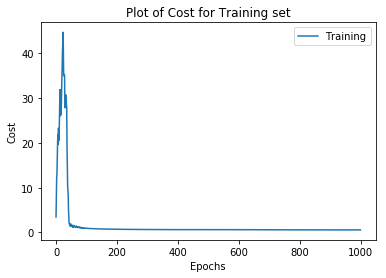

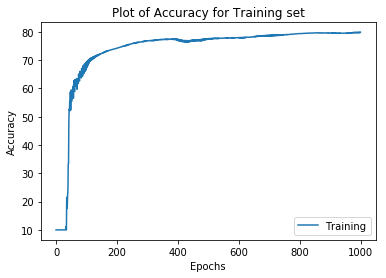


Neural Network with SGD accuracy for training set:  79.86%
Neural Network accuracy with SGD for Test set: 78.21%

Confusion Matrix:



,T-shirt,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle-Boot
T-shirt,923,19,40,9,0,3,0,2,0,0
Trouser,1,699,17,189,2,60,0,16,0,0
Pullover,14,13,834,79,1,23,0,3,0,0
Dress,1,154,40,716,1,76,0,12,0,0
Coat,0,0,8,1,807,0,71,17,95,0
Sandal,5,158,66,212,1,350,0,41,0,0
Shirt,0,0,0,0,30,0,895,1,74,0
Sneaker,1,16,14,10,9,15,5,925,3,0
Bag,0,0,2,0,26,0,53,2,917,0
Ankle-Boot,0,0,0,0,0,0,0,0,0,0


In [218]:
plt.plot(range(0,sgd_epochs), error_cost, label='Training') 
plt.title('Model Loss')
plt.xlabel('Epochs') 
plt.ylabel('Cost') 
plt.title('Plot of Cost for Training set') 
plt.legend(loc='upper right')
plt.savefig('sgd_Cost_lr_'+str(lr)+'_and_epochs_'+str(sgd_epochs)+'.png')
plt.show()

plt.plot(range(0,sgd_epochs), train_acc, label='Training') 
plt.title('Model Accuracy')
plt.xlabel('Epochs') 
plt.ylabel('Accuracy') 
plt.title('Plot of Accuracy for Training set') 
plt.legend(loc='lower right')
plt.savefig('sgd_Accuracy_lr_'+str(lr)+'_and_epochs_'+str(sgd_epochs)+'.png')
plt.show()

#Here after training, the updated weights are used to calculate the predictions on the test set and the accuracy
#is calculated
test_predictions = predict(sgd_nn_test_data)
test_acc = getAccuracy(test_label,test_predictions)

print(formatting.BOLD + "\nNeural Network with SGD accuracy for training set: " + 
      formatting.END,str(np.round(train_acc[len(train_acc)-1],2)) + "%")
print(formatting.BOLD + "Neural Network accuracy with SGD for Test set:" + 
      formatting.END,str(np.round(test_acc,2)) + "%")

sgd_nn_cnfmatrx = skm.confusion_matrix(test_label,test_predictions,labels=classLabels)
sgd_nn_cnfmatrx_df = pd.DataFrame(
    sgd_nn_cnfmatrx, 
    index=classNames, 
    columns=classNames
)
print(formatting.BOLD + "\nConfusion Matrix:\n" + formatting.END)
sgd_nn_cnfmatrx_df

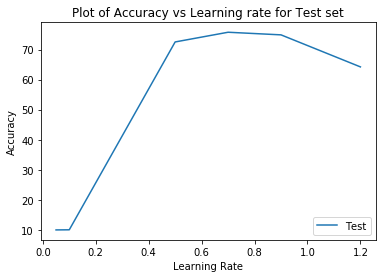

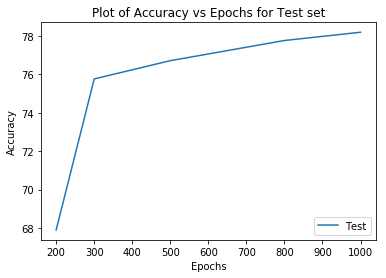

In [219]:
# SGD NN plotting Learning rates taken while testing and corresponding accuracies achieved while epochs are fixed at 
# 300. All the test cases run are mentioned in the report.
sgd_NN_lrs = [0.05,0.1,0.5,0.7,0.9,1.2]
sgd_NN_accs = [9.98,10.02,72.53,75.76,74.89,64.23]
plt.plot(sgd_NN_lrs, sgd_NN_accs,label='Test') 
plt.xlabel('Learning Rate') 
plt.ylabel('Accuracy') 
plt.title('Plot of Accuracy vs Learning rate for Test set') 
plt.legend(loc='lower right')
plt.savefig('sgd_accuracyvslr.png')
plt.show()

# SGD NN plotting epochs taken while testing and corresponding accuracies achieved while keeping learning rate at 0.7
# All the test cases run are mentioned in the report.
sgd_NN_epochs = [200,300,500,800,1000]
sgd_NN_accs = [67.9,75.76,76.71,77.76,78.19]
plt.plot(sgd_NN_epochs, sgd_NN_accs,label='Test') 
plt.xlabel('Epochs') 
plt.ylabel('Accuracy') 
plt.title('Plot of Accuracy vs Epochs for Test set') 
plt.legend(loc='lower right')
plt.savefig('sgd_accuracyvsepochs.png')
plt.show()

# Multilayer Neural Network

## Define the Model

Here we define a model that we will use for training. We create the layers and the optimizer to be used as well as the learning rate. These are varied to find the optimum accuracy.

In [228]:
def getNNModel():
  # initialize model
  model = Sequential()

  # add input layer
  model.add(Dense(128,input_dim=nn_train_data.shape[1]))
  model.add(Activation('relu'))
  model.add(Dropout(0.1))

  # add hidden layer
  model.add(Dense(64))
  model.add(Activation('relu'))
  model.add(Dropout(0.1))
    
  # add output layer
  model.add(Dense(10))
  model.add(Activation('softmax'))

  model.summary()

  # define optimizer
  #optimizer = keras.optimizers.SGD(lr=0.02)
  #optimizer = keras.optimizers.RMSprop(lr=0.001)
  optimizer = keras.optimizers.Adam(lr=0.001)

  # compile model
  model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])
  return model

In [229]:
nn_train_data = nn_train_data.reshape(len(train_label),784)
print("nn_train_data shape:", nn_train_data.shape, "train_label shape:", train_label.shape)
nn_test_data = nn_test_data.reshape(len(nn_test_data),784)
print("nn_test_data shape:", nn_test_data.shape, "test_label shape:", test_label.shape)

nn_train_data shape: (60000, 784) train_label shape: (60000,)
nn_test_data shape: (10000, 784) test_label shape: (10000,)


## Train the Model

Here we train the model on the training data from which we take 16% as validation set.

In [230]:
# train model
NNModel = getNNModel()
nn_epochs = 300
print("Number of epochs: ",nn_epochs)
nn_modelBatchSize = 128
nn_earlyPatience = 100
nn_earlystopping_cb = EarlyStopping(monitor='val_loss', verbose=1, patience=nn_earlyPatience, mode='min')

nn_history = NNModel.fit(nn_train_data, 
                    nn_train_labels_1hot, 
                    validation_split=0.16, 
                    epochs=nn_epochs, 
                    batch_size=nn_modelBatchSize, 
                    callbacks = [nn_earlystopping_cb], 
                    verbose = 1)
print("Neural Network Training Ended.")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 128)               100480    
_________________________________________________________________
activation_14 (Activation)   (None, 128)               0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 64)                8256      
_________________________________________________________________
activation_15 (Activation)   (None, 64)                0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_35 (Dense)             (None, 10)                650       
__________

50400/50400 [==============================] - 2s 31us/step - loss: 0.1559 - acc: 0.9402 - val_loss: 0.3556 - val_acc: 0.8926
Epoch 50/300
50400/50400 [==============================] - 2s 31us/step - loss: 0.1492 - acc: 0.9423 - val_loss: 0.3591 - val_acc: 0.8952
Epoch 51/300
50400/50400 [==============================] - 2s 32us/step - loss: 0.1464 - acc: 0.9436 - val_loss: 0.3642 - val_acc: 0.8949
Epoch 52/300
50400/50400 [==============================] - 2s 34us/step - loss: 0.1477 - acc: 0.9444 - val_loss: 0.3685 - val_acc: 0.8965
Epoch 53/300
50400/50400 [==============================] - 2s 39us/step - loss: 0.1482 - acc: 0.9435 - val_loss: 0.3598 - val_acc: 0.8933
Epoch 54/300
50400/50400 [==============================] - 3s 52us/step - loss: 0.1431 - acc: 0.9460 - val_loss: 0.3698 - val_acc: 0.8914
Epoch 55/300
50400/50400 [==============================] - 3s 51us/step - loss: 0.1431 - acc: 0.9448 - val_loss: 0.3694 - val_acc: 0.8967
Epoch 56/300
50400/50400 [==============

Epoch 108/300
50400/50400 [==============================] - 2s 37us/step - loss: 0.0985 - acc: 0.9624 - val_loss: 0.4919 - val_acc: 0.8874
Epoch 109/300
50400/50400 [==============================] - 2s 44us/step - loss: 0.0981 - acc: 0.9629 - val_loss: 0.4725 - val_acc: 0.8920
Epoch 110/300
50400/50400 [==============================] - 2s 42us/step - loss: 0.1044 - acc: 0.9595 - val_loss: 0.4519 - val_acc: 0.8999
Epoch 111/300
50400/50400 [==============================] - 2s 43us/step - loss: 0.1006 - acc: 0.9618 - val_loss: 0.4586 - val_acc: 0.8911
Epoch 112/300
50400/50400 [==============================] - 2s 43us/step - loss: 0.0978 - acc: 0.9636 - val_loss: 0.4622 - val_acc: 0.8930
Epoch 113/300
50400/50400 [==============================] - 2s 46us/step - loss: 0.0935 - acc: 0.9636 - val_loss: 0.4701 - val_acc: 0.8947
Epoch 114/300
50400/50400 [==============================] - 2s 37us/step - loss: 0.0966 - acc: 0.9624 - val_loss: 0.4713 - val_acc: 0.8961
Epoch 115/300
50400/

## Plot the Training Accuracies and Test the Model on Test Data

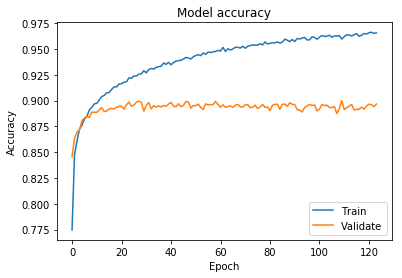

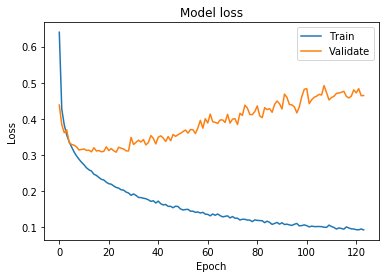

10000/10000 [==============================] - 0s 18us/step

Neural Network accuracy for training set:  96.54563492063491
Neural Network accuracy for validation set:  89.65625
Neural Network accuracy for Test set: 88.88

Confusion Matrix:



,T-shirt,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle-Boot
T-shirt,976,0,13,4,0,6,0,1,0,0
Trouser,0,831,13,68,0,66,0,2,0,0
Pullover,11,9,891,27,0,34,0,6,0,0
Dress,0,104,33,802,0,55,0,6,0,0
Coat,0,0,1,0,974,0,13,1,11,0
Sandal,0,92,25,62,0,699,0,10,0,0
Shirt,0,0,0,0,15,0,971,0,14,0
Sneaker,0,3,4,4,5,4,4,970,0,0
Bag,0,0,0,0,9,0,48,0,942,0
Ankle-Boot,0,0,0,0,0,0,0,0,0,0


In [231]:
plotModelHistory(nn_history)

# Here we calculate the accuracy on the test set after our model is trained.
nn_score = NNModel.evaluate(nn_test_data, nn_test_labels_1hot, batch_size=nn_modelBatchSize)
nn_predtargets = NNModel.predict(nn_test_data) 
nn_predtargets = getSoftPredictions(nn_predtargets)

print(formatting.BOLD + "\nNeural Network accuracy for training set: " + 
      formatting.END,nn_history.history['acc'][len(nn_history.history['acc'])-1] * 100)
print(formatting.BOLD + "Neural Network accuracy for validation set: " + 
      formatting.END,nn_history.history['val_acc'][len(nn_history.history['val_acc'])-1] * 100)
print(formatting.BOLD + "Neural Network accuracy for Test set:" + 
      formatting.END,np.round(nn_score[1]*100,2))

nn_cnfmatrx = skm.confusion_matrix(test_label,nn_predtargets,labels=classLabels)
nn_confmatrix = pd.DataFrame(
    nn_cnfmatrx, 
    index=classNames, 
    columns=classNames
)
print(formatting.BOLD + "\nConfusion Matrix:\n" + formatting.END)
nn_confmatrix

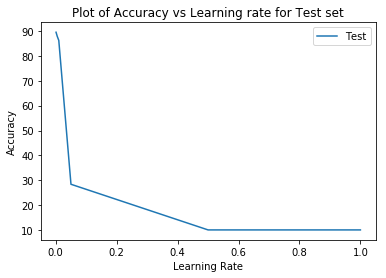

In [232]:
# plotting Learning rates taken while testing and corresponding accuracies achieved. 
# All the test cases run have been reported in the report.
NN_lrs = [0.001,0.005,0.01,0.05,0.5,1]
NN_accs = [89.54,87.87,86.25,28.37,10.0,10.0]
plt.plot(NN_lrs, NN_accs,label='Test') 
plt.xlabel('Learning Rate') 
plt.ylabel('Accuracy') 
plt.title('Plot of Accuracy vs Learning rate for Test set') 
plt.legend(loc='upper right')
plt.savefig('nn_accuracyvslr.png')
plt.show()

# Convolutional Neural Network

In [233]:
img_rows, img_cols = 28, 28
cnn_train_data = cnn_train_data.reshape(cnn_train_data.shape[0], img_rows, img_cols, 1)
cnn_test_data = cnn_test_data.reshape(cnn_test_data.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

print('cnn_train_data shape:', cnn_train_data.shape)
print(cnn_train_data.shape[0], 'cnn_train_data samples')
print(cnn_test_data.shape[0], 'cnn_test_data samples')

cnn_train_data shape: (60000, 28, 28, 1)
60000 cnn_train_data samples
10000 cnn_test_data samples


Here we define the model for our convolutional neural network. We vary the number of layer, nodes, optimizer, learning rate and dropouts to achieve the optimum accuracy.

## Define the Model

In [234]:
def getCNNModel():
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3,3) ,padding='same', activation='relu',input_shape=input_shape))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(64, (3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  #model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(Flatten())
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(10, activation='softmax'))
  model.summary()

  #define optimizer
  #optimizer = keras.optimizers.SGD(lr=0.02)
  #optimizer = keras.optimizers.RMSprop(lr=0.001)
  optimizer = keras.optimizers.Adam(lr=0.0005)
  #optimizer = keras.optimizers.Adadelta(lr=0.25)

  # compile model
  model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])
  return model

## Train the Model

Here we train our model on the training set and take 16% of it as the validation set.

In [235]:
CNNModel = getCNNModel()
cnn_epochs = 300
print("Number of epochs: ",cnn_epochs)
cnn_modelBatchSize = 128
cnn_earlyPatience = 100
cnn_earlystopping_cb = EarlyStopping(monitor='val_loss', verbose=1, patience=cnn_earlyPatience, mode='min')

cnn_history = CNNModel.fit(cnn_train_data, 
                    cnn_train_labels_1hot, 
                    validation_split=0.16, 
                    epochs=cnn_epochs, 
                    batch_size=cnn_modelBatchSize, 
                    callbacks = [cnn_earlystopping_cb], 
                    verbose = 1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 2304)              0         
_________________________________________________________________
dense_36 (Dense)             (None, 64)                147520    
__________

50400/50400 [==============================] - 5s 101us/step - loss: 0.1778 - acc: 0.9341 - val_loss: 0.2145 - val_acc: 0.9287
Epoch 49/300
50400/50400 [==============================] - 6s 109us/step - loss: 0.1746 - acc: 0.9344 - val_loss: 0.2255 - val_acc: 0.9239
Epoch 50/300
50400/50400 [==============================] - 5s 107us/step - loss: 0.1724 - acc: 0.9359 - val_loss: 0.2103 - val_acc: 0.9285
Epoch 51/300
50400/50400 [==============================] - 5s 106us/step - loss: 0.1719 - acc: 0.9358 - val_loss: 0.2117 - val_acc: 0.9301
Epoch 52/300
50400/50400 [==============================] - 5s 109us/step - loss: 0.1684 - acc: 0.9368 - val_loss: 0.2120 - val_acc: 0.9297
Epoch 53/300
50400/50400 [==============================] - 5s 109us/step - loss: 0.1668 - acc: 0.9358 - val_loss: 0.2137 - val_acc: 0.9269
Epoch 54/300
50400/50400 [==============================] - 5s 105us/step - loss: 0.1643 - acc: 0.9384 - val_loss: 0.2107 - val_acc: 0.9311
Epoch 55/300
50400/50400 [=======

50400/50400 [==============================] - 5s 103us/step - loss: 0.1204 - acc: 0.9523 - val_loss: 0.2422 - val_acc: 0.9324
Epoch 107/300
50400/50400 [==============================] - 5s 99us/step - loss: 0.1194 - acc: 0.9528 - val_loss: 0.2360 - val_acc: 0.9316
Epoch 108/300
50400/50400 [==============================] - 5s 102us/step - loss: 0.1193 - acc: 0.9544 - val_loss: 0.2501 - val_acc: 0.9302
Epoch 109/300
50400/50400 [==============================] - 5s 104us/step - loss: 0.1216 - acc: 0.9525 - val_loss: 0.2392 - val_acc: 0.9305
Epoch 110/300
50400/50400 [==============================] - 5s 101us/step - loss: 0.1196 - acc: 0.9533 - val_loss: 0.2434 - val_acc: 0.9291
Epoch 111/300
50400/50400 [==============================] - 5s 101us/step - loss: 0.1203 - acc: 0.9537 - val_loss: 0.2429 - val_acc: 0.9307
Epoch 112/300
50400/50400 [==============================] - 5s 102us/step - loss: 0.1154 - acc: 0.9555 - val_loss: 0.2453 - val_acc: 0.9266
Epoch 113/300
50400/50400 [=

# Plot the Training Accuracies and Test the Model on Test Data

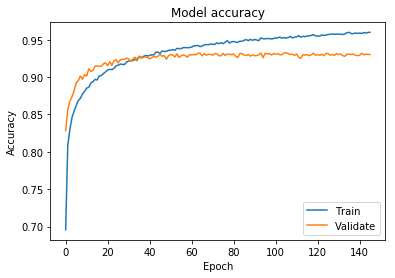

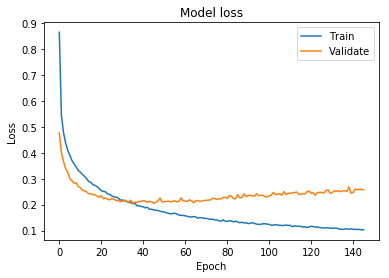

10000/10000 [==============================] - 1s 126us/step

Convulational Neural Network accuracy for training set:  95.9980158768003
Convulational Neural Network accuracy for validation set:  93.01041666666666
Convulational Neural Network accuracy for Test set: 92.76

Confusion Matrix:



,T-shirt,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle-Boot
T-shirt,988,1,7,1,0,0,0,1,0,0
Trouser,0,902,5,32,0,46,0,0,0,0
Pullover,1,8,929,24,0,23,0,0,0,0
Dress,0,37,24,895,0,43,0,1,0,0
Coat,0,0,0,0,984,0,11,0,5,0
Sandal,0,52,23,49,0,763,0,8,0,0
Shirt,0,0,0,0,5,0,983,0,12,0
Sneaker,1,1,3,3,2,2,2,985,0,0
Bag,0,0,0,0,4,1,33,0,962,0
Ankle-Boot,0,0,0,0,0,0,0,0,0,0


In [236]:
plotModelHistory(cnn_history)

# Here we use the trained model to get the predictions on the test set and calculate the accuracy of our model.
cnn_score = CNNModel.evaluate(cnn_test_data, cnn_test_labels_1hot)
cnn_predtargets = CNNModel.predict(cnn_test_data) 
cnn_predtargets = getSoftPredictions(cnn_predtargets)

print(formatting.BOLD + "\nConvulational Neural Network accuracy for training set: " + 
      formatting.END,cnn_history.history['acc'][len(cnn_history.history['acc'])-1] * 100)
print(formatting.BOLD + "Convulational Neural Network accuracy for validation set: " + 
      formatting.END,cnn_history.history['val_acc'][len(cnn_history.history['val_acc'])-1] * 100)
print(formatting.BOLD + "Convulational Neural Network accuracy for Test set:" + 
      formatting.END,np.round(cnn_score[1]*100,2))

cnn_cnfmatrx = skm.confusion_matrix(test_label,cnn_predtargets,labels=classLabels)
cnn_confmatrix = pd.DataFrame(
    cnn_cnfmatrx, 
    index=classNames, 
    columns=classNames
)
print(formatting.BOLD + "\nConfusion Matrix:\n" + formatting.END)
cnn_confmatrix


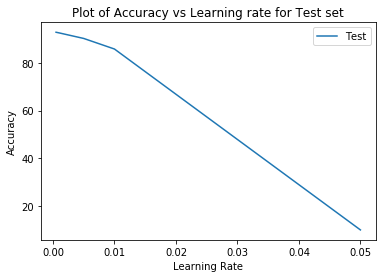

In [237]:
# plotting Learning rates taken while testing and corresponding accuracies achieved
# All the test cases run have been reported in the report.
CNN_lrs = [0.0005,0.001,0.005,0.01,0.05]
CNN_accs = [92.81,92.54,90.21,85.78,10.0]
plt.plot(CNN_lrs, CNN_accs,label='Test') 
plt.xlabel('Learning Rate') 
plt.ylabel('Accuracy') 
plt.title('Plot of Accuracy vs Learning rate for Test set') 
plt.legend(loc='upper right')
plt.savefig('cnn_accuracyvslr.png')
plt.show()